In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from pprint import pprint
import re
import json
import gzip
class LTEParser:
    _mapa = {
        "B": "#Bearer",
        "T": "TimeStamp",
        "TX": "Transmission",
        "RX": "Receiver",
        "D": "Delay",
        "ID": "#Packet",
        "DST": "Destiny",
        "SRC": "Source",
        "SIZE": "Size"
    }
    @staticmethod
    def parse(inFile, flowDuration = 100):
        #VIDEO
        videoAverages = []
        videoFairness = []
        videoDelay = []
        videoJitter = []
        videoPLR = []
        #VOICE
        voiceAverages = []
        voiceFairness = []
        voiceDelay = []
        voiceJitter = []
        voicePLR = []
        #INFBUF
        infBufAverages = []
        infBufFairness = []
        infBufDelay = []
        infBufJitter = []
        infBufPLR = []
        #GERAL
        packetLoss = []
        for sfile in inFile:
            content = ""
            print("Opening file: " + sfile)
            with gzip.open(sfile, 'rb') as file:
                content = file.read()
                content = content.decode('utf-8')
            print("Parsing file ...", end="")
            txContent, rxContent = LTEParser._parse(content)
            info = LTEParser.getFairnessIndex(rxContent, flowDuration)
            packetLossInfo = LTEParser.getPacketLossRatio(txContent, rxContent)
            delayInfo = LTEParser.getDelayJitter(rxContent)
            #VIDEO
            videoAverages.append(info['VIDEO']['Average'])
            videoFairness.append(info['VIDEO']['FairnessIndex'])
            videoDelay.append(delayInfo['VIDEO']['Average'])
            videoJitter.append(delayInfo['VIDEO']['StD'])
            videoPLR.append(packetLossInfo[1]['VIDEO'])
            #VOICE
            voiceAverages.append(info['VOIP']['Average'])
            voiceFairness.append(info['VOIP']['FairnessIndex'])
            voiceDelay.append(delayInfo['VOIP']['Average'])
            voiceJitter.append(delayInfo['VOIP']['StD'])
            voicePLR.append(packetLossInfo[1]['VOIP'])
            #INFBUF
            infBufAverages.append(info['WEB']['Average'])
            infBufFairness.append(info['WEB']['FairnessIndex'])
            infBufDelay.append(delayInfo['WEB']['Average'])
            infBufJitter.append(delayInfo['WEB']['StD'])
            infBufPLR.append(packetLossInfo[1]['WEB'])
            #GERAL
            packetLoss.append(packetLossInfo[0])
        return [#VIDEO
                (sum(videoAverages)/len(videoAverages)),
                (sum(videoFairness)/len(videoFairness)),
                (sum(videoDelay)/len(videoDelay)),
                (sum(videoJitter)/len(videoJitter)),
                (sum(videoPLR)/len(videoPLR)),
                #VOICE
                (sum(voiceAverages)/len(voiceAverages)),
                (sum(voiceFairness)/len(voiceFairness)),
                (sum(voiceDelay)/len(voiceDelay)),
                (sum(voiceJitter)/len(voiceJitter)),
                (sum(voicePLR)/len(voicePLR)),
                #INFBUF
                (sum(infBufAverages)/len(infBufAverages)),
                (sum(infBufFairness)/len(infBufFairness)),
                (sum(infBufDelay)/len(infBufDelay)),
                (sum(infBufJitter)/len(infBufJitter)),
                (sum(infBufPLR)/len(infBufPLR)),
                #GERAL
                packetLoss]
    @staticmethod
    def _parse(content):
        txContent = LTEParser.parseTX(content)
        rxContent = LTEParser.parseRX(content)
        print("Done")
        return txContent, rxContent
    
    @staticmethod
    def parseTX(content):
        matches = re.findall(r"(^TX.+)", content, re.MULTILINE)
        if(matches == []):
            raise Exception("No matches in content for TX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        keys = dictPacketType.keys()
        for match in matches:
            values = match.split(' ')
            if values[1] in keys:
                tamanho = len(values)
                dic = {}
                for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                    dic[LTEParser._mapa[values[i]]] = values[i+1]
                dic = dict(sorted(dic.items(), key=lambda x: x[0]))
                dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
        
    @staticmethod        
    def parseRX(content):
        matches = re.findall(r"(^RX.+)", content, re.MULTILINE)
        if(matches == []):
            raise Exception("No matches in content for RX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        keys = dictPacketType.keys()
        for match in matches:
            values = match.split(' ')
            if values[1] in keys:
                tamanho = len(values)
                dic = {}
                for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                    dic[LTEParser._mapa[values[i]]] = values[i+1]
                dic = dict(sorted(dic.items(), key=lambda x: x[0]))
                dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
    
    @staticmethod
    def getPacketLossRatio(txContent, rxContent):
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        tx_pkts = 0
        rx_pkts = 0
        for key in txContent:
            keytx = len(txContent[key])
            tx_pkts += keytx
            keyrx = len(rxContent[key])
            rx_pkts += keyrx
            keyPLR = ((keytx - keyrx) / (keytx if keytx != 0 else 1)) * 100
            dictPacketType[key] = keyPLR
        plr = ((tx_pkts - rx_pkts) / tx_pkts) * 100
        return plr, dictPacketType
    
    @staticmethod
    def getDelayJitter(rxContent):
        delayPerApp = {}
        for app in rxContent:
            delayPerApp[app] = {"Sum": 0, "Average": 0, "StD": 0}
            delayPerApp[app]["Sum"] = sum(float(item["Delay"]) for item in rxContent[app])
            tamanho = len(rxContent[app])
            delayPerApp[app]["Average"] = delayPerApp[app]["Sum"]/tamanho if tamanho != 0 else 0
            delayPerApp[app]["StD"] = sum((float(item["Delay"]) - delayPerApp[app]["Average"])**2 for item in rxContent[app])/ (tamanho - 1) if tamanho != 0 else 0
        return delayPerApp
    
    @staticmethod
    def getGoodput(rxContent, flowDuration):
        gputPerApp = {}
        for app in rxContent:
            gputPerApp[app] = {"Sum": 0, "Average": 0}
            gputPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
            gputPerApp[app]["Average"] = (gputPerApp[app]["Sum"])/flowDuration
        return gputPerApp
    
    @staticmethod
    def getThroughput(rxContent, flowDuration):
        tputPerApp = {}
        for app in rxContent:
            tputPerApp[app] = {"Sum": 0, "Average": 0}
            tputPerApp[app]["Sum"] = sum((float(item["Size"]) + 5)*8 for item in rxContent[app])
            tputPerApp[app]["Average"] = (tputPerApp[app]["Sum"])/flowDuration
        return tputPerApp
    
    @staticmethod
    def getSpectralEff():
        pass
    
    @staticmethod
    def getFairnessIndex(rxContent, flowDuration):
        fairnessPerApp = {}
        for app in rxContent:
            fairnessPerApp[app] = {"Sum": 0, "Average": 0, "SumSquared": 0, "SquaredSum": 0, "FairnessIndex": 0}
            if(len(rxContent[app]) > 0):
                fairnessPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
                fairnessPerApp[app]["Average"] = (fairnessPerApp[app]["Sum"])/flowDuration
                fairnessPerApp[app]["SumSquared"] = sum(pow(float(item["Size"])*8,2) for item in rxContent[app])
                fairnessPerApp[app]["SquaredSum"] = pow(fairnessPerApp[app]["Sum"], 2)
                division = (len(rxContent[app]) * fairnessPerApp[app]["SumSquared"])
                fairnessPerApp[app]["FairnessIndex"] = fairnessPerApp[app]["SquaredSum"] / division if division > 0 else 1
        return fairnessPerApp

In [14]:
base = "../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition"
ext = ".gz"
until = 4
users = 51
files = {
         1: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         2: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}, 
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         3: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         4: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         5: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             },
         6: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             },
         7: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             }
        }
for sched in range(1,8):
    for ue in range(10, users, 10):
        for vel in [3]:
            for count in range(1,until):
                file = "/SCHED_" + str(sched) + "_UE_" + str(ue) + "_V_" + str(vel) +"_D_.1_" + str(count)
                filename = base + file + ext
                files[sched][vel][ue].append(filename)

In [15]:
#VIDEO
GPUTSVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
FAIRVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
DELAYVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
JITTERVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
PLRVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
#VOICE
GPUTSVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
FAIRVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
DELAYVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
JITTERVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
PLRVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
#INFBUF
GPUTSINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
FAIRINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
DELAYINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
JITTERINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
PLRINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
#GERAL
PACKETLOSS = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
for sched in GPUTSVIDEO:
    for ue in range(10, users, 10):
        info = LTEParser.parse(files[sched][3][ue], 100)
        #VIDEO
        GPUTSVIDEO[sched].append(info[0])
        FAIRVIDEO[sched].append(info[1])
        DELAYVIDEO[sched].append(info[2])
        JITTERVIDEO[sched].append(info[3])
        PLRVIDEO[sched].append(info[4])
        #VOICE
        GPUTSVOICE[sched].append(info[5])
        FAIRVOICE[sched].append(info[6])
        DELAYVOICE[sched].append(info[7])
        JITTERVOICE[sched].append(info[8])
        PLRVOICE[sched].append(info[9])
        #INFBUF
        GPUTSINFBUF[sched].append(info[10])
        FAIRINFBUF[sched].append(info[11])
        DELAYINFBUF[sched].append(info[12])
        JITTERINFBUF[sched].append(info[13])
        PLRINFBUF[sched].append(info[14])
        #GERAL
        PACKETLOSS[sched].append(info[15])
    #VIDEO
    GPUTSVIDEO[sched] = np.array(GPUTSVIDEO[sched], dtype=np.float32)
    FAIRVIDEO[sched] = np.array(FAIRVIDEO[sched], dtype=np.float32)
    DELAYVIDEO[sched] = np.array(DELAYVIDEO[sched], dtype = np.float32)
    JITTERVIDEO[sched] = np.array(JITTERVIDEO[sched], dtype = np.float32)
    PLRVIDEO[sched] = np.array(PLRVIDEO[sched], dtype = np.float32)
    #VOICE
    GPUTSVOICE[sched] = np.array(GPUTSVOICE[sched], dtype=np.float32)
    FAIRVOICE[sched] = np.array(FAIRVOICE[sched], dtype=np.float32)
    DELAYVOICE[sched] = np.array(DELAYVOICE[sched], dtype = np.float32)
    JITTERVOICE[sched] = np.array(JITTERVOICE[sched], dtype = np.float32)
    PLRVOICE[sched] = np.array(PLRVOICE[sched], dtype = np.float32)
    #INFBUF
    GPUTSINFBUF[sched] = np.array(GPUTSINFBUF[sched], dtype=np.float32)
    FAIRINFBUF[sched] = np.array(FAIRINFBUF[sched], dtype=np.float32)
    DELAYINFBUF[sched] = np.array(DELAYINFBUF[sched], dtype = np.float32)
    JITTERINFBUF[sched] = np.array(JITTERINFBUF[sched], dtype = np.float32)
    PLRINFBUF[sched] = np.array(PLRINFBUF[sched], dtype = np.float32)
    #GERAL
    PACKETLOSS[sched] = np.array(PACKETLOSS[sched], dtype=np.float32)

Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_1_UE_20_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_1_UE_20_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_1_UE_20_V_3_D_.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_1_UE_30_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_1_UE_30_V_3_D_.1_2.gz
Parsing file ...Done
Opening 

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_5_UE_30_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_5_UE_30_V_3_D_.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_5_UE_50_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_5_UE_50_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_WebApp_ConstantPosition/SCHED_5_UE_50_V_3_D_.1_3.gz
Parsing 

# VIDEO
## GPUT

In [16]:
MEGAVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
for sched in GPUTSVIDEO:
    MEGAVIDEO[sched] = np.true_divide(GPUTSVIDEO[sched], 1e+6)

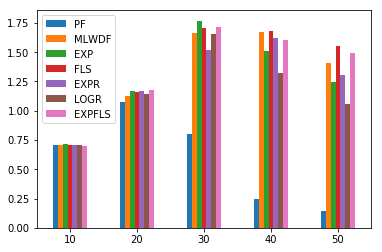

In [18]:
dfGPUTVIDEO = pd.DataFrame({'PF': MEGAVIDEO[1], 'MLWDF': MEGAVIDEO[2], 'EXP': MEGAVIDEO[3],
                       'FLS': MEGAVIDEO[4], 'EXPR': MEGAVIDEO[5], 'LOGR': MEGAVIDEO[6], 'EXPFLS': MEGAVIDEO[7]},
                      index=[10,20,30,40,50])
plot = dfGPUTVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVideo.pdf", bbox_inches='tight')

In [19]:
dfGPUTVIDEO

,PF,MLWDF,EXP,FLS,EXPR,LOGR,EXPFLS
10,0.706692,0.705408,0.711998,0.711352,0.710541,0.706286,0.702873
20,1.075094,1.128242,1.171196,1.155817,1.165017,1.141239,1.179699
30,0.802822,1.667914,1.768776,1.706901,1.522728,1.653021,1.717411
40,0.245526,1.669638,1.508595,1.684693,1.619520,1.319664,1.603141
50,0.141569,1.408216,1.246372,1.554775,1.308774,1.060572,1.496390


## Delay

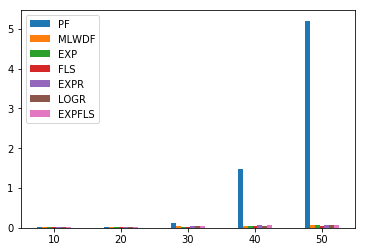

In [20]:
dfDELAYVIDEO = pd.DataFrame({'PF': DELAYVIDEO[1], 'MLWDF': DELAYVIDEO[2], 'EXP': DELAYVIDEO[3],
                            'FLS': DELAYVIDEO[4], 'EXPR': DELAYVIDEO[5], 'LOGR': DELAYVIDEO[6], 'EXPFLS': DELAYVIDEO[7]},
                           index=[10,20,30,40,50])
plot = dfDELAYVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideoPF.pdf", bbox_inches='tight')

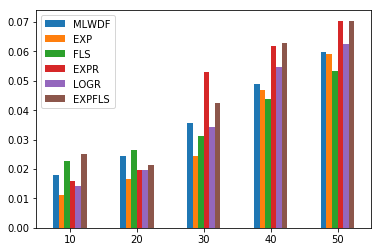

In [21]:
dfDELAYVIDEO = pd.DataFrame({'MLWDF': DELAYVIDEO[2], 'EXP': DELAYVIDEO[3],
                            'FLS': DELAYVIDEO[4], 'EXPR': DELAYVIDEO[5],
                             'LOGR': DELAYVIDEO[6], 'EXPFLS': DELAYVIDEO[7]},
                           index=[10,20,30,40,50])
plot = dfDELAYVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideo.pdf", bbox_inches='tight')

## JITTER

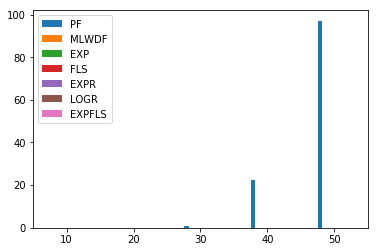

In [22]:
dfJITTERVIDEO = pd.DataFrame({'PF': JITTERVIDEO[1], 'MLWDF': JITTERVIDEO[2], 'EXP': JITTERVIDEO[3],
                            'FLS': JITTERVIDEO[4], 'EXPR': JITTERVIDEO[5], 'LOGR': JITTERVIDEO[6], 'EXPFLS': JITTERVIDEO[7]},
                           index=[10,20,30,40,50])
plot = dfJITTERVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideoPF.pdf", bbox_inches='tight')

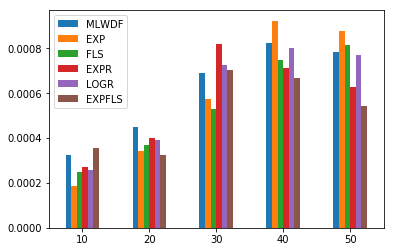

In [23]:
dfJITTERVIDEO = pd.DataFrame({'MLWDF': JITTERVIDEO[2], 'EXP': JITTERVIDEO[3],
                            'FLS': JITTERVIDEO[4], 'EXPR': JITTERVIDEO[5],
                            'LOGR': JITTERVIDEO[6], 'EXPFLS': JITTERVIDEO[7]},
                           index=[10,20,30,40,50])
plot = dfJITTERVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideo.pdf", bbox_inches='tight')

## FAIRNESS

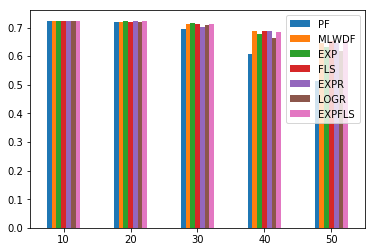

In [25]:
dfFAIRVIDEO = pd.DataFrame({'PF': FAIRVIDEO[1], 'MLWDF': FAIRVIDEO[2], 'EXP': FAIRVIDEO[3],
                            'FLS': FAIRVIDEO[4], 'EXPR': FAIRVIDEO[5], 'LOGR': FAIRVIDEO[6],
                           'EXPFLS': FAIRVIDEO[7]},
                           index=[10,20,30,40,50])
plot = dfFAIRVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessVideo.pdf", bbox_inches='tight')

## PLR

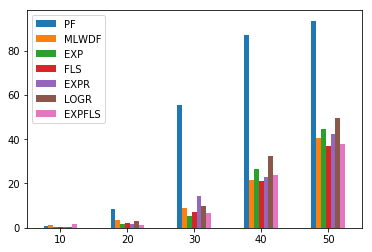

In [29]:
dfPLRVIDEO = pd.DataFrame({'PF': PLRVIDEO[1], 'MLWDF': PLRVIDEO[2], 'EXP': PLRVIDEO[3],
                            'FLS': PLRVIDEO[4], 'EXPR': PLRVIDEO[5], 'LOGR': PLRVIDEO[6],
                          'EXPFLS': PLRVIDEO[7]},
                           index=[10,20,30,40,50])
plot = dfPLRVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossVideo.pdf", bbox_inches='tight')

# VOIP
## GPUT

In [30]:
MEGAVOIP = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
for sched in GPUTSVOICE:
    MEGAVOIP[sched] = np.true_divide(GPUTSVOICE[sched], 1e+6)

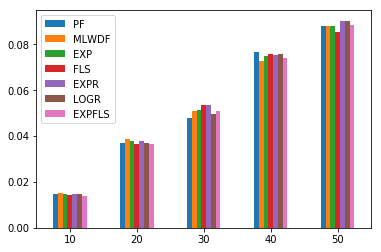

In [31]:
dfGPUTVOICE = pd.DataFrame({'PF': MEGAVOIP[1], 'MLWDF': MEGAVOIP[2], 'EXP': MEGAVOIP[3],
                       'FLS': MEGAVOIP[4], 'EXPR': MEGAVOIP[5], 'LOGR': MEGAVOIP[6], 'EXPFLS': MEGAVOIP[7]},
                      index=[10,20,30,40,50])
plot = dfGPUTVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVoIP.pdf", bbox_inches='tight')

## Delay

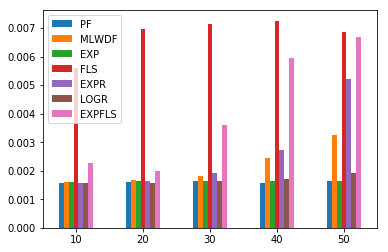

In [32]:
dfDELAYVOICE = pd.DataFrame({'PF': DELAYVOICE[1], 'MLWDF': DELAYVOICE[2], 'EXP': DELAYVOICE[3],
                            'FLS': DELAYVOICE[4], 'EXPR': DELAYVOICE[5], 'LOGR': DELAYVOICE[6],
                            'EXPFLS': DELAYVOICE[7]},
                           index=[10,20,30,40,50])
plot = dfDELAYVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIPPF.pdf", bbox_inches='tight')

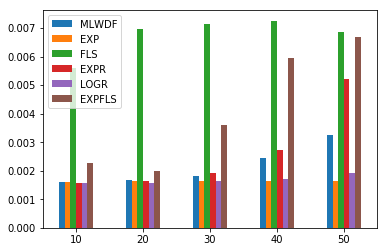

In [33]:
dfDELAYVOICE = pd.DataFrame({'MLWDF': DELAYVOICE[2], 'EXP': DELAYVOICE[3],
                            'FLS': DELAYVOICE[4], 'EXPR': DELAYVOICE[5],
                            'LOGR': DELAYVOICE[6],'EXPFLS': DELAYVOICE[7]},
                           index=[10,20,30,40,50])
plot = dfDELAYVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIP.pdf", bbox_inches='tight')

## Jitter

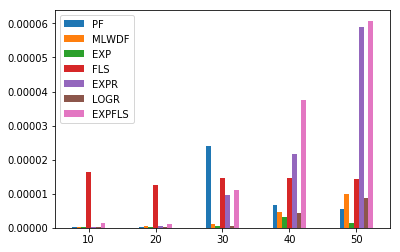

In [34]:
dfJITTERVOICE = pd.DataFrame({'PF': JITTERVOICE[1], 'MLWDF': JITTERVOICE[2], 'EXP': JITTERVOICE[3],
                            'FLS': JITTERVOICE[4], 'EXPR': JITTERVOICE[5], 'LOGR': JITTERVOICE[6],
                             'EXPFLS': JITTERVOICE[7]},
                           index=[10,20,30,40,50])
plot = dfJITTERVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIPPF.pdf", bbox_inches='tight')

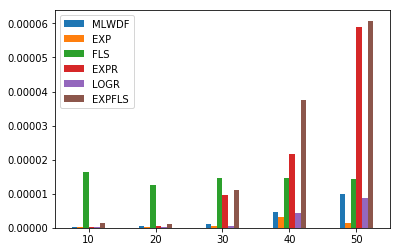

In [35]:
dfJITTERVOICE = pd.DataFrame({'MLWDF': JITTERVOICE[2], 'EXP': JITTERVOICE[3],
                            'FLS': JITTERVOICE[4], 'EXPR': JITTERVOICE[5],
                            'LOGR': JITTERVOICE[6], 'EXPFLS': JITTERVOICE[7]},
                           index=[10,20,30,40,50])
plot = dfJITTERVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIP.pdf", bbox_inches='tight')

## FAIRNESS

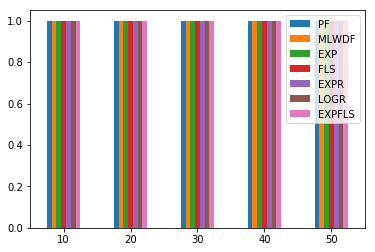

In [36]:
dfFAIRVOICE = pd.DataFrame({'PF': FAIRVOICE[1], 'MLWDF': FAIRVOICE[2], 'EXP': FAIRVOICE[3],
                            'FLS': FAIRVOICE[4], 'EXPR': FAIRVOICE[5], 'LOGR': FAIRVOICE[6],
                           'EXPFLS': FAIRVOICE[7]},
                           index=[10,20,30,40,50])
plot = dfFAIRVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessVoice.pdf", bbox_inches='tight')

## PLR

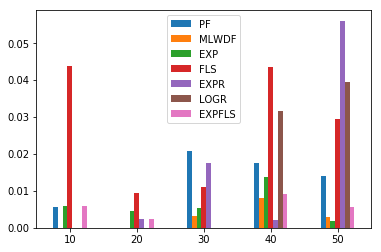

In [37]:
dfPLRVOICE = pd.DataFrame({'PF': PLRVOICE[1], 'MLWDF': PLRVOICE[2], 'EXP': PLRVOICE[3],
                            'FLS': PLRVOICE[4], 'EXPR': PLRVOICE[5], 'LOGR': PLRVOICE[6],
                          'EXPFLS': PLRVOICE[7]},
                           index=[10,20,30,40,50])
plot = dfPLRVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossVoice.pdf", bbox_inches='tight')

# WEB
## GPUT

In [38]:
MEGAINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
for sched in GPUTSINFBUF:
    MEGAINFBUF[sched] = np.true_divide(GPUTSINFBUF[sched], 1e+6)

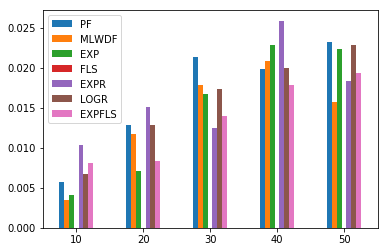

In [40]:
dfGPUTINFBUF = pd.DataFrame({'PF': MEGAINFBUF[1], 'MLWDF': MEGAINFBUF[2], 'EXP': MEGAINFBUF[3],
                       'FLS': MEGAINFBUF[4], 'EXPR': MEGAINFBUF[5], 'LOGR': MEGAINFBUF[6],
                        'EXPFLS': MEGAINFBUF[7]},
                      index=[10,20,30,40,50])
plot = dfGPUTINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTWeb.pdf", bbox_inches='tight')

## Delay

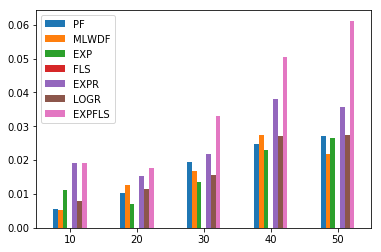

In [43]:
dfDELAYINFBUF = pd.DataFrame({'PF': DELAYINFBUF[1], 'MLWDF': DELAYINFBUF[2], 'EXP': DELAYINFBUF[3],
                            'FLS': DELAYINFBUF[4], 'EXPR': DELAYINFBUF[5], 'LOGR': DELAYINFBUF[6],
                             'EXPFLS': DELAYINFBUF[7]},
                           index=[10,20,30,40,50])
plot = dfDELAYINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayWeb.pdf", bbox_inches='tight')

## Jitter

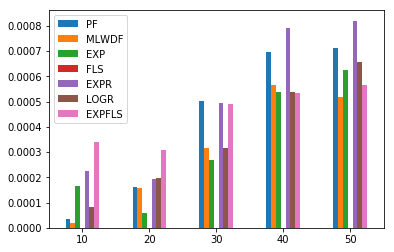

In [46]:
dfJITTERINFBUF = pd.DataFrame({'PF': JITTERINFBUF[1], 'MLWDF': JITTERINFBUF[2], 'EXP': JITTERINFBUF[3],
                            'FLS': JITTERINFBUF[4], 'EXPR': JITTERINFBUF[5], 'LOGR': JITTERINFBUF[6],
                            'EXPFLS': JITTERINFBUF[7]},
                           index=[10,20,30,40,50])
plot = dfJITTERINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterWebPF.pdf", bbox_inches='tight')

## FAIRNESS

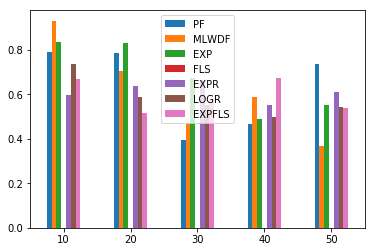

In [48]:
dfFAIRINFBUF = pd.DataFrame({'PF': FAIRINFBUF[1], 'MLWDF': FAIRINFBUF[2], 'EXP': FAIRINFBUF[3],
                            'FLS': FAIRINFBUF[4], 'EXPR': FAIRINFBUF[5], 'LOGR': FAIRINFBUF[6],
                            'EXPFLS': FAIRINFBUF[7]},
                           index=[10,20,30,40,50])
plot = dfFAIRINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessWeb.pdf", bbox_inches='tight')

## PLR

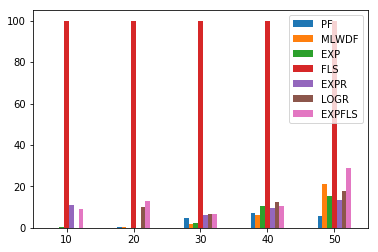

In [49]:
dfPLRINFBUF = pd.DataFrame({'PF': PLRINFBUF[1], 'MLWDF': PLRINFBUF[2], 'EXP': PLRINFBUF[3],
                            'FLS': PLRINFBUF[4], 'EXPR': PLRINFBUF[5], 'LOGR': PLRINFBUF[6],
                           'EXPFLS': PLRINFBUF[7]},
                           index=[10,20,30,40,50])
plot = dfPLRINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossWeb.pdf", bbox_inches='tight')

# Loss Ratio

In [50]:
averagePacketLoss = {}
for key in PACKETLOSS:
    averagePacketLoss[key] = []
    for i in range(0, 5):
        average = sum(PACKETLOSS[key][i])/len(PACKETLOSS[key][i])
        averagePacketLoss[key].append(average)

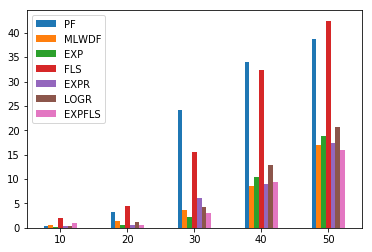

In [51]:
dfLossRatio = pd.DataFrame({'PF': averagePacketLoss[1], 'MLWDF': averagePacketLoss[2], 'EXP': averagePacketLoss[3],
                            'FLS': averagePacketLoss[4], 'EXPR': averagePacketLoss[5], 'LOGR': averagePacketLoss[6],
                           'EXPFLS': averagePacketLoss[7]},
                           index=[10,20,30,40,50])
plot = dfLossRatio.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossRatio.pdf", bbox_inches='tight')

FLS + EXPRULE
Priorização do FLS, 